In [1]:
import sys

sys.path.insert(0, '../')

from modules.VT_dataset import *
from modules.train_prep import *
from modules.plot_results import *

In [2]:
class EEGCNN(nn.Module):
    def __init__(self, num_classes=4):
        # Initialize the EEGCNN class as a subclass of nn.Module.
        super(EEGCNN, self).__init__()

        # First convolutional layer with 16 filters, kernel size of (3, 40), and padding to preserve the time dimension.
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 40), padding=(1, 20))
        # Batch normalization for the first convolutional layer to stabilize learning.
        self.bn1 = nn.BatchNorm2d(16)

        # Second convolutional layer with 32 filters, kernel size of (3, 25), and padding to preserve the time dimension.
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 25), padding=(1, 12))
        # Batch normalization for the second convolutional layer.
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional layer with 64 filters, kernel size of (3, 10), and padding to preserve the time dimension.
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 10), padding=(1, 5))
        # Batch normalization for the third convolutional layer.
        self.bn3 = nn.BatchNorm2d(64)

        # Max pooling layer to reduce the spatial dimensions of the output from convolutional layers.
        self.pool = nn.MaxPool2d((2, 4))

        # Dropout layer with 0.25 probability, used to prevent overfitting by randomly zeroing some of the elements.
        self.dropout1 = nn.Dropout(0.25)
        # Another dropout layer with a higher dropout rate of 0.5.
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layer to reduce the dimension from the flattened output to 100.
        self.fc1 = nn.Linear(19456, 100)  # 64 channels * 17 height * 20 width = 19456
        # Second fully connected layer that maps the 100 features to the number of classes.
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        # Define the forward pass through the network.
        x = x.unsqueeze(1)  # Add a channel dimension to the input if needed (for greyscale images).

        # First convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Second convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Third convolutional layer followed by batch normalization, a leaky ReLU activation, and pooling.
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Apply the first dropout layer.
        x = self.dropout1(x)
        
        # Flatten the output of the last pooling layer to prepare it for the fully connected layer.
        x = torch.flatten(x, 1)

        # Fully connected layer with a leaky ReLU activation.
        x = F.leaky_relu(self.fc1(x))

        # Apply the second dropout layer before the final fully connected layer.
        x = self.dropout2(x)

        # Final fully connected layer that outputs the predictions.
        x = self.fc2(x)
        
        return x

In [3]:
# Check and set the appropriate device (GPU or MPS) based on availability.
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_device)  # Set the specific GPU device if CUDA is available.
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")  # Set the MPS device for Apple Silicon chips if available.

# Define transformations to apply to training and validation datasets. Currently, it converts images to PyTorch tensors.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format.
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),  # Convert images to tensor format.
    ]),
}

# Initialize datasets for training and validation using the specified directories and behavioral files.
dsets = {
    'train': RawDataset(train_dir, train_behav_file, data_transforms['train']),
    'val': RawDataset(val_dir, val_behav_file, data_transforms['val'])
}
# Calculate the number of samples in each dataset.
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}

# Initialize data loaders for training and validation, configuring class balancing via weighted sampling.
dset_loaders = {}
for split in ['train', 'val']:
    # Extract labels for all entries in the dataset to calculate class weights.
    targets = np.array([dsets[split].get_label(i) for i in range(len(dsets[split]))])
    # Count occurrences of each class to address class imbalance.
    class_counts = dsets[split].get_class_counts()
    # Compute weights for each sample, inversely proportional to class frequency.
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])
    # Create a sampler for weighted sampling, which helps in dealing with imbalanced data by adjusting the likelihood of sample selection.
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    # Define the DataLoader for each dataset split, using the custom sampler and specifying batch size and number of workers.
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=b_size, num_workers=0, sampler=sampler)
    # Confirmation message to indicate completion of DataLoader setup for each dataset split.
    print('done making loader:', split)

# Initialize the EEGCNN model, specifying the number of classes for the output layer.
model_ft = EEGCNN(num_classes=4)
# Define the loss function, using cross-entropy loss which is common for classification tasks.
criterion = nn.CrossEntropyLoss()
# Configure the optimizer, using Adam algorithm with a specified learning rate and weight decay for regularization.
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-5)

# Determine the device to train on, prioritizing CUDA (GPU), MPS (Apple Silicon), or defaulting to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Move the model and loss function to the chosen device to enable GPU/MPS acceleration.
model_ft.to(device)
criterion.to(device)
# Print the device being used for training to confirm the setup.
print(f"Training on {device}")

# Function call to train the model, passing the model, loss function, optimizer, learning rate scheduler, data loaders, dataset sizes, and number of epochs.
# This function presumably handles the entire training process including forward and backward passes, and learning rate adjustments.
model_ft, accuracies, losses, preds, labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dset_loaders, dset_sizes, num_epochs=n_epochs)

  0%|          | 0/192 [00:00<?, ?it/s]

100%|██████████| 192/192 [00:07<00:00, 25.20it/s]


Class counts:  {'HEHF': 2489, 'HELF': 238, 'LEHF': 1371, 'LELF': 878}


100%|██████████| 48/48 [00:01<00:00, 26.59it/s]


Class counts:  {'HEHF': 508, 'HELF': 101, 'LEHF': 535, 'LELF': 100}
done making loader: train
done making loader: val
Training on mps


----------
Epoch 0/0
----------
LR is set to 0.0001

In train phase:


2490it [01:24, 29.59it/s]                          


train Loss: 1.3851 Acc: 0.3485

In val phase:


625it [00:17, 36.16it/s]                         
100%|██████████| 1/1 [01:41<00:00, 101.60s/it]

val Loss: 1.3721 Acc: 0.3087
New best accuracy = 0.3087
Training complete in 1m 42s
Best val Acc: 0.3087


train accuracies by epoch: [array(0.34847265, dtype=float32)]
train losses by epoch: [1.3850602912462027]
val accuracies by epoch: [array(0.30868167, dtype=float32)]
val losses by epoch: [1.3721140281947095]


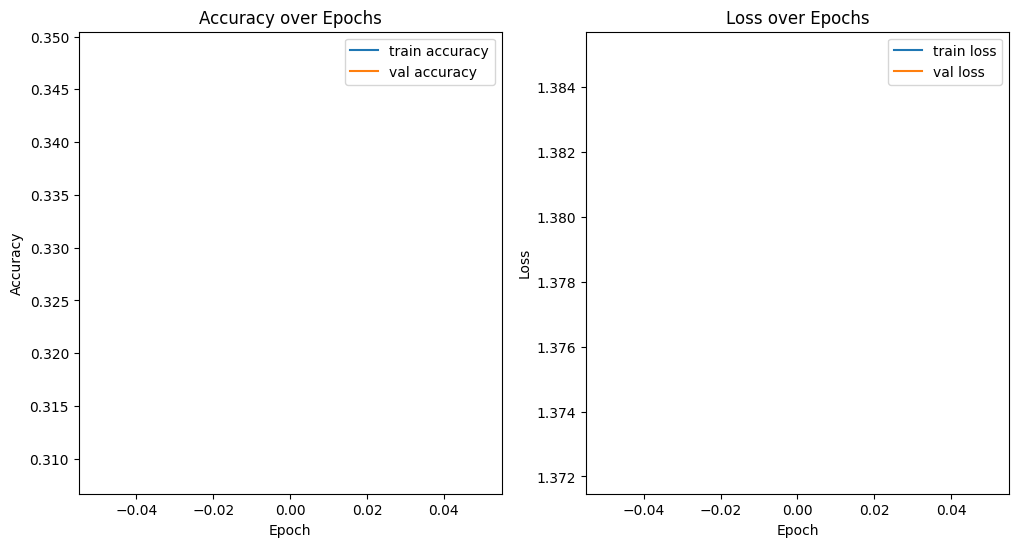

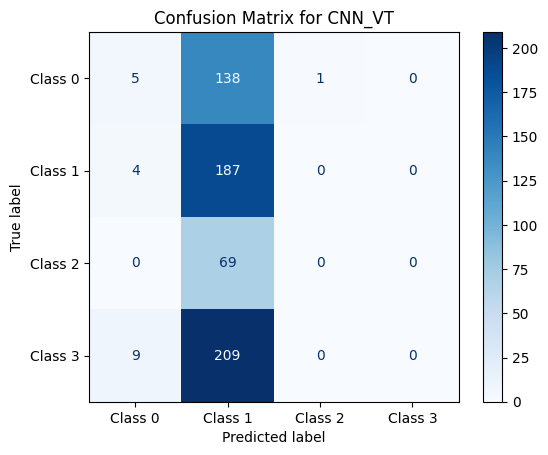

In [4]:
# Loop over each dataset split ('train' and 'val') and print out accuracies and losses for each epoch.
for split in ['train', 'val']:
    # Print the accuracies for each epoch. The `accuracies` dictionary likely contains lists of accuracies per epoch for each split.
    print(split, 'accuracies by epoch:', accuracies[split])
    # Print the losses for each epoch. The `losses` dictionary similarly contains lists of losses per epoch for each split.
    print(split, 'losses by epoch:', losses[split])

# Save the trained model's state dictionary to a file. This allows the model to be re-loaded later with the exact same parameters.
torch.save(model_ft.state_dict(), '../../models/CNN_VT_best_model.pt')

# Call a function to plot the training history.
# This function likely generates plots of accuracies and losses over the epochs, providing a visual representation of the training process.
plot_training_history(accuracies, losses, 'CNN_VT')

# Call a function to plot a confusion matrix.
# The confusion matrix compares the labels predicted by the model against the true labels,
# providing insight into how well the model is performing across different classes.
plot_confusion_matrix(labels, preds, 'CNN_VT')